```accel-realapps-ann-runtime-single.ipynb```
#    <font color='red'>GPU optimal frequency selection using Machine Learning Model</font>
##   _Source_Data_:  ML – A100 SXM <br>
#### _Date_:    ***20220827*** <br>
###  _Authors_: Ghazanfar ALI *and* Mert SIDE <br>

> ***for the paper titled:*** Performance-Aware Energy-Efficient GPU Frequency Selection using DNN-based Models <br>
> ***venue:*** Machine Learning in HPC Environments Workshop at SC22

<hr style="border:2px solid gray">


***README***

First three code cells are used to include the needed libraries, sets global variables, and define shared functions. Please run them before running anything else


___
### IMPORT LIBRARIES AND SET GLOBAL VARIABLES

In [1]:
#!/usr/bin/python3

# IMPORT LIBRARIES AND SET GLOBAL VARIABLES ----------------------------------

# GENERIC
import sys
import statistics
import itertools
import datetime as dt
from os import error
from typing_extensions import runtime

# NUMPY
import numpy as np
from numpy.lib import type_check
from numpy.core.fromnumeric import mean

# PANDAS
import pandas as pd

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import Normalize
from matplotlib.offsetbox import (TextArea, 
                                  DrawingArea, 
                                  OffsetImage, 
                                  AnnotationBbox)
from matplotlib.patches import Rectangle

# SEABORN
import seaborn as sns
from seaborn.palettes import color_palette

# SKLEARN
import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.utils import shuffle

# MISC.
# from xgboost import XGBRegressor

xss = 6
ss  = 7   # 8
ms  = 8   # 10
ls  = 9   # 12
xls = 14
xxls = 16

matplotlib.rc('xtick', labelsize=ss) 
matplotlib.rc('ytick', labelsize=ss) 

figureExtension = '.pdf'
# figureExtension = '.png'
# figureExtension = '.svg'
preferredDPI = 400
# ============================================================================

___
### Set global color, hatch and marker standards

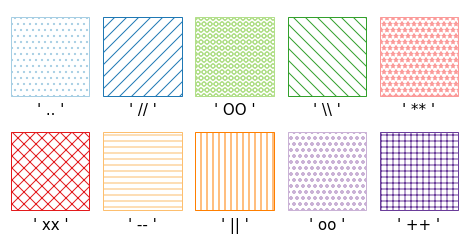

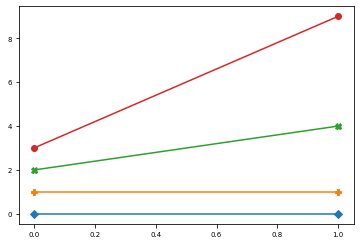

In [2]:
# DEMO hatches ===============================================================
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(6.4, 3.2),
                        facecolor='white')

# SWATCHES -------------------------------------------------------------------
baseColors  = sns.color_palette("Paired")
baseHatches = ['..', '//', 'OO', '\\\\', '**', 'xx', '--', '||', 'oo', '++'] # ['oo', 'xx', '++', '//', '\\\\', '--', '||', '..', '**', 'OO']
baseMarkers = ['D', 'P', 'X', 'o'] # ['o', 'X', 'P', 'D']
alternateColors = ['r', 'g', 'b', 'm', 'y', 'c']
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

markerSize = 50

baseLineColor = 'deeppink'
baseLinewidth = 2
baseArrowColor = 'tomato'
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
# https://matplotlib.org/stable/api/markers_api.html

# colors = itertools.cycle(['r','g', 'b', 'm', 'y', 'c'])
# MARKERS ['o', '+', '*', '.', 'x', '_', '|', 's', 'd', '^', 'v', 
#          '>', '<', 'p', 'h', 'X', '8', '1', '2',',','P']

colors=itertools.cycle(baseColors)
hatches=itertools.cycle(baseHatches)
markers=itertools.cycle(baseMarkers)

def hatches_plot(ax, h):
    ax.add_patch(Rectangle((0, 0), 2, 2, fill=False, hatch=h, color=next(colors)))
    ax.text(1, -0.5, f"' {h} '", size=15, ha='center')
    ax.axis('equal')
    ax.axis('off')

for ax, h in zip(axs.flat, hatches):
    hatches_plot(ax, h)
   
plt.show()

plt.close()

i = 0
for m in baseMarkers:
    plt.plot([i, i*i], marker=next(markers))
    i = i + 1
# END OF DEMO hatches ========================================================

___
### Global Functions

In [3]:
def learning_curve(hist):
    '''
    plt.plot(hist.history['mean_absolute_percentage_error'])
    plt.title('Model Error')
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    # plt.legend(['Train', 'Val'], loc='lower right')
    plt.grid(True)
    plt.show()
    '''
    '''
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
    '''
    print (min(hist.history['mean_absolute_percentage_error']))

In [4]:

def pltdata(X_test,y_test,hist):
    y_pred = model.predict(X_test)
    
    print (mean_absolute_percentage_error (y_test,y_pred))
    
    '''
    plt.plot(y_test, color = 'red', label = 'Real data')
    plt.plot(y_pred, color = 'blue', label = 'Predicted data')
    plt.title('Prediction')
    plt.legend()
    plt.show()
    plt.close()
    '''
#     learning_curve(hist)

In [5]:
def predict_data(hist):
    # f = 'GA100-dvfs-dgemm-dcgm.csv'
    # data2 = pd.read_csv(f)
    # data2['fp_active'] = data2['fp64_active'].add(data2['fp32_active'].div(2))

    # for app in validation_apps:
    #     data2 = df.loc[df['application'] == app]
    #     if model_name == 'n_run_time':
    #         data2[model_name] = data2['run_time'].div(max(data2['run_time']))
    apps = ['NAMD','LAMMPS','GROMACS','LSTM']
    for app in apps:
        print ('************',app,'************')
    #     f = 'GA100-dvfs-'+app+'-dcgm.csv'
        f = 'GA100_am_energy_rt_pwr_'+app+'.csv'
        dat = pd.read_csv(f)    
        if model_name == 'n_run_time':
            dat[model_name] = dat['run_time'].div(max(dat['run_time']))
        dat['fp_active'] = dat['fp64_active'].add(dat['fp32_active'].div(2)) # 
    #     dat['fp_active'] = dat['fp64_active'].add(dat['fp32_active'])
    #     if app == 'dgemm':
    #         dat['fp_active'] = dat['tensor_activity']
    #     elif app == 'stream':
    #         dat['fp_active'] = dat['fp64_active']

        df2 = dat[['fp_active','dram_active','sm_app_clock',model_name]]
        df2 = df2.copy()
        dataset2 = df2.values
        X_test = dataset2[:, :-1]
        y_test = dataset2[:, -1]
        X_test = sc.transform(X_test)
        pltdata (X_test,y_test,hist)

___
___
___


2022-12-05 13:53:53.619098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 13:56:20.140951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


selu <keras.optimizers.optimizer_experimental.rmsprop.RMSprop object at 0x130c73a60>
6 7
************ NAMD ************
2/2 [==============================] - 0s 2ms/step
    Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1   ID  gr_engine_active  sm_active  \
0              0           0             0  0.0          0.743437   0.649794   
1              1           1             1  0.0          0.753020   0.667235   
2              2           2             2  0.0          0.760158   0.676088   
3              3           3             3  0.0          0.749739   0.665952   
4              4           4             4  0.0          0.747784   0.664220   
..           ...         ...           ...  ...               ...        ...   
56            56          56            56  0.0          0.873333   0.780514   
57            57          57            57  0.0          0.873583   0.788421   
58            58          58            58  0.0          0.876083   0.786803   
59            59          59 

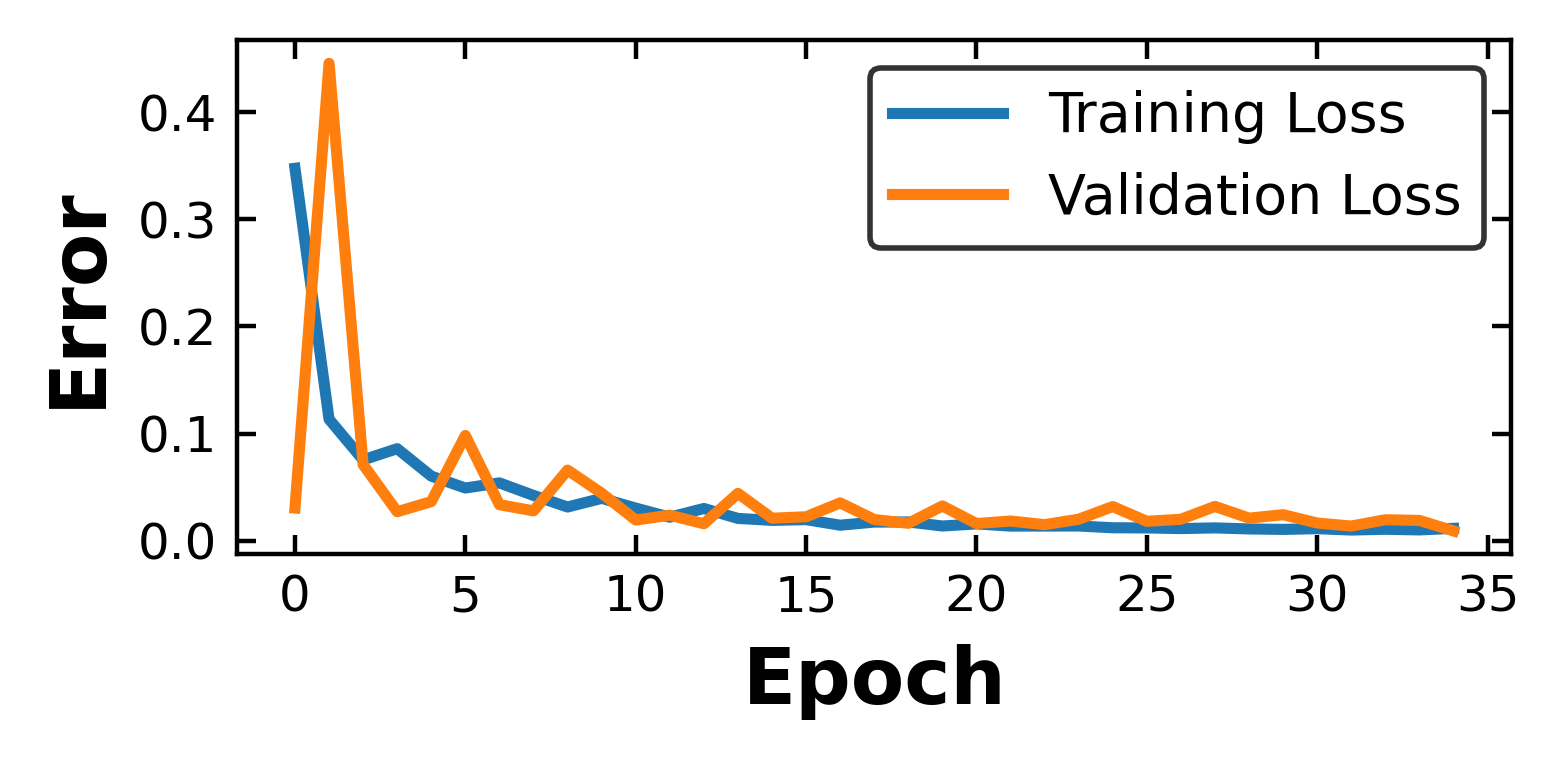

************ LAMMPS ************
2/2 [==============================] - 0s 3ms/step
    Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1   ID  gr_engine_active  sm_active  \
0              0           0             0  0.0          0.964445   0.963634   
1              1           1             1  0.0          0.964357   0.964294   
2              2           2             2  0.0          0.964331   0.962637   
3              3           3             3  0.0          0.958757   0.956953   
4              4           4             4  0.0          0.967839   0.966616   
..           ...         ...           ...  ...               ...        ...   
56            56          56            56  0.0          0.982884   0.976959   
57            57          57            57  0.0          0.984557   0.979087   
58            58          58            58  0.0          0.980269   0.976949   
59            59          59            59  0.0          0.981756   0.978469   
60            60          60        

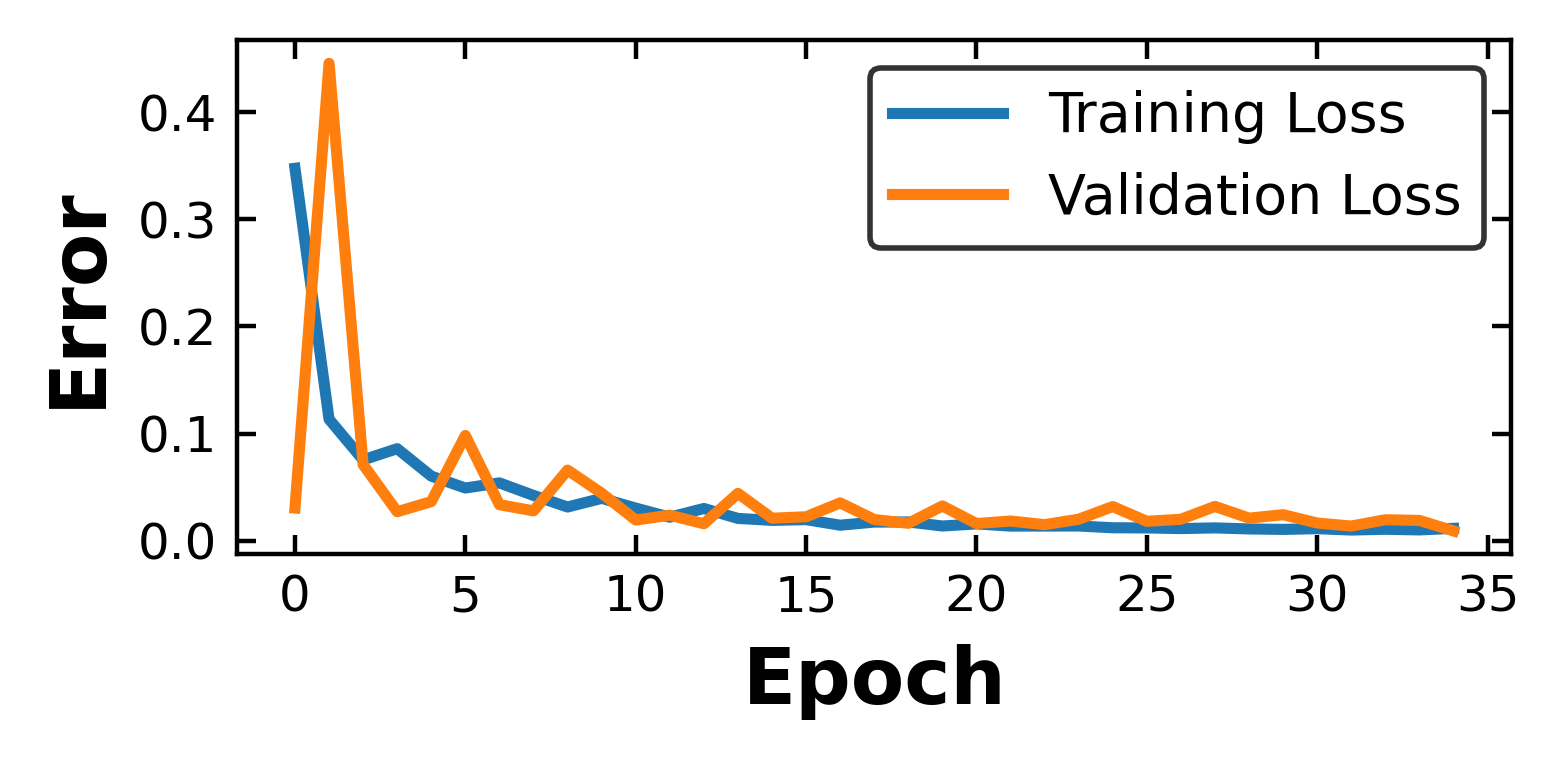

************ GROMACS ************
2/2 [==============================] - 0s 7ms/step
    Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1   ID  gr_engine_active  sm_active  \
0              0           0             0  0.0          0.212130   0.214039   
1              1           1             1  0.0          0.204135   0.215362   
2              2           2             2  0.0          0.195601   0.192465   
3              3           3             3  0.0          0.205992   0.208817   
4              4           4             4  0.0          0.215720   0.227765   
..           ...         ...           ...  ...               ...        ...   
56            56          56            56  0.0          0.453105   0.480145   
57            57          57            57  0.0          0.465721   0.499649   
58            58          58            58  0.0          0.469422   0.463506   
59            59          59            59  0.0          0.475921   0.488378   
60            60          60       

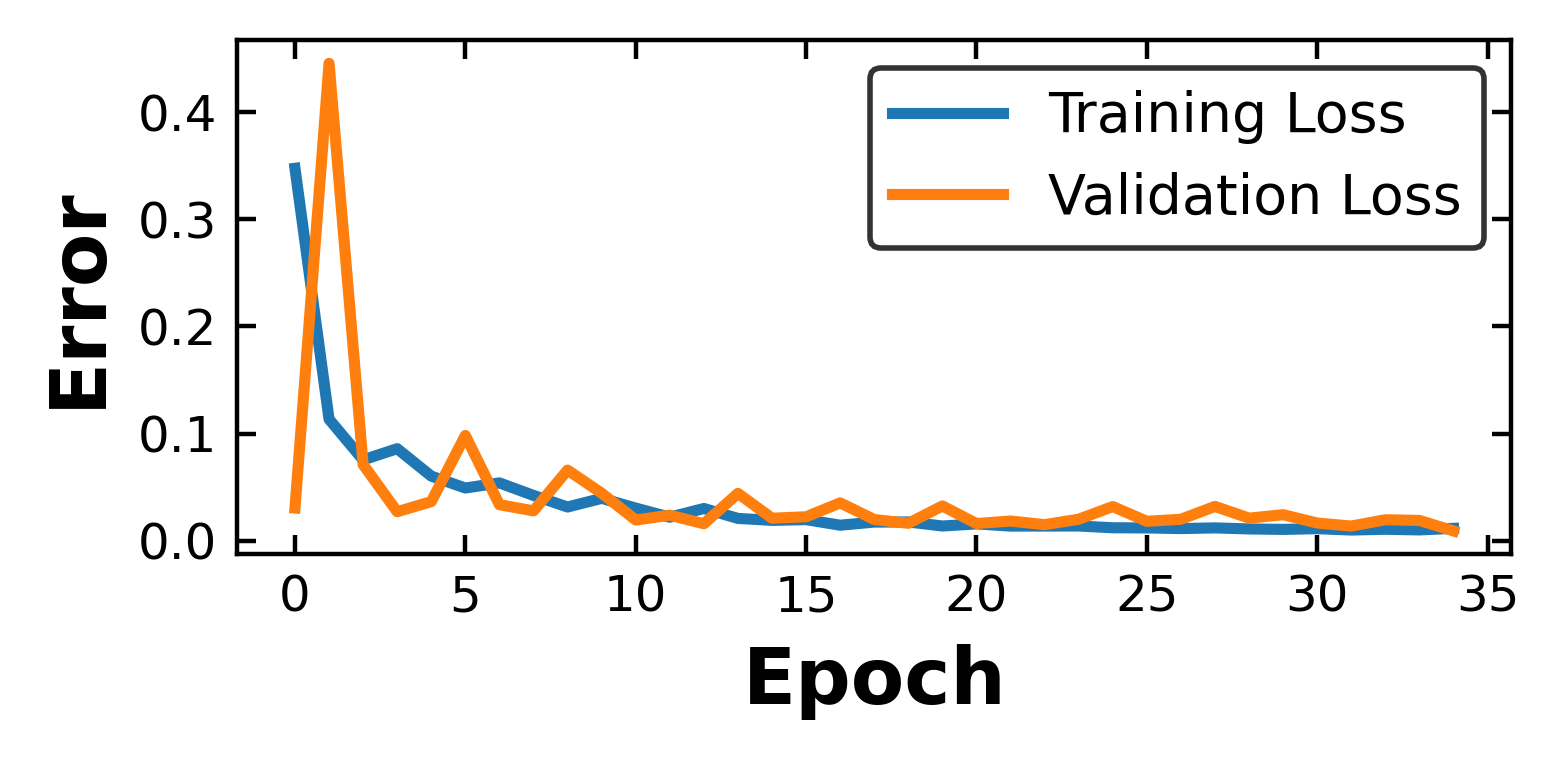

************ LSTM ************
2/2 [==============================] - 0s 4ms/step
    Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1   ID  gr_engine_active  sm_active  \
0              0           0             0  0.0          0.416432   0.027811   
1              1           1             1  0.0          0.399950   0.029725   
2              2           2             2  0.0          0.403737   0.024404   
3              3           3             3  0.0          0.402085   0.028017   
4              4           4             4  0.0          0.395059   0.022353   
..           ...         ...           ...  ...               ...        ...   
56            56          56            56  0.0          0.724839   0.045359   
57            57          57            57  0.0          0.791824   0.052730   
58            58          58            58  0.0          0.799265   0.050325   
59            59          59            59  0.0          0.815985   0.056604   
60            60          60          

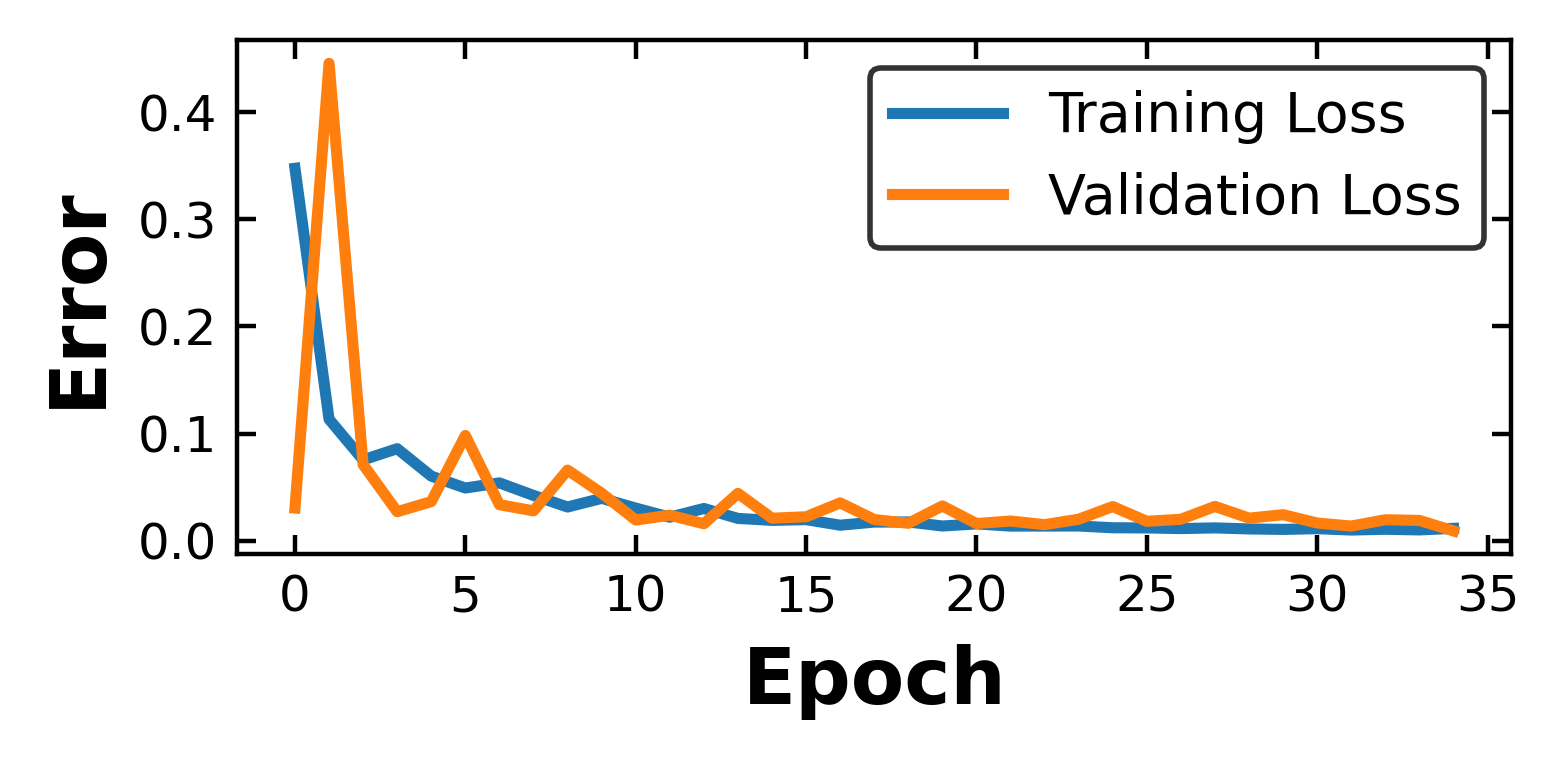

{'NAMD': [96.21], 'LAMMPS': [95.33], 'GROMACS': [75.56], 'LSTM': [90.43]}


In [6]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf

from keras.layers import Dropout
from keras import regularizers
from sklearn.metrics import mean_absolute_percentage_error

# # for power model
# from numpy.random import seed
# s = 1 
# seed(s)
# tf.random.set_seed(s+1)

# SWATCHES -------------------------------------------------------------------
colors  = itertools.cycle(baseColors[0:2])
hatches = itertools.cycle(baseHatches)
markers = itertools.cycle(baseMarkers)
marker_size = markerSize
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

'''
# opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# opt = tf.keras.optimizers.Adam(learning_rate=0.002) # with elu (time)
# opt = tf.keras.optimizers.Adadelta(learning_rate=0.01)
# opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)
# opt = tf.keras.optimizers.Adamax(learning_rate=0.01) #  with tanh (power)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
# opt = tf.keras.optimizers.Ftrl(learning_rate=0.01)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.01) # with relu (time)

if model_name == 'n_run_time':
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
elif model_name == 'power_usage':
    opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
'''

'''
if model_name == 'n_run_time':
    act_func = 'elu'
elif model_name == 'power_usage':
    act_func = 'tanh'
# sigmoid,relu,softmax,softplus,softsign,selu, tanh, elu, exponential

'''

SPEC_dataPath = "../datasets/SPEC_A100/"
dgemm_Stream_DataPath = "../datasets/dgemm_stream/"
HPC_DataPath = "../datasets/hpc/"

models = ['power_usage','n_run_time']
# act_funcs = ['sigmoid','relu','softmax','softplus','softsign','selu', 'tanh', 'elu']
# act_funcs = ['selu', 'elu', 'relu', 'tanh', 'sigmoid']
'''
from tensorflow.keras.layers import PReLU, Dense
para_relu = PReLU()
act_funcs = [para_relu]
'''
'''
from tensorflow.keras.layers import LeakyReLU, Dense
leaky_relu = LeakyReLU(alpha=0.03)
act_funcs = [leaky_relu]
'''
act_funcs = ['selu']
# opts = [tf.keras.optimizers.Adam(),tf.keras.optimizers.Adamax(),tf.keras.optimizers.Nadam(),tf.keras.optimizers.RMSprop()]
# opts = [tf.keras.optimizers.Adamax(learning_rate=0.005)]
opts = [tf.keras.optimizers.RMSprop()]
model_name = 'n_run_time'
# model_name = 'power_usage'
# bm = 'microbm'
df_list = []
app_acc_list = {'NAMD':[],'LAMMPS':[],'GROMACS':[],'LSTM':[]}
f = SPEC_dataPath + 'GA100-dvfs-accel-dcgm.csv'
df = pd.read_csv(f)
# df['fp_active'] = df['fp32_active']
df['fp_active'] = df['fp64_active'].add(df['fp32_active'].div(2))

if model_name == 'n_run_time':
    df_l = []
    hpc_apps = ["nw", "kmeans", "ge","tpacf","histo", "cutcp", "srad", "bfs", "spmv", "mriq","stencil","lbm", "bplustree", "fft", "cfd", "lud", "heartwall","lavamd", "hotspot"]
    for hpc_app in hpc_apps:
        hpc_app_df = df.loc[df['application'] == hpc_app]
        hpc_app_df = hpc_app_df.copy()
        hpc_app_df[model_name] = hpc_app_df['run_time'].div(max(hpc_app_df['run_time']))
        df_l.append(hpc_app_df)
    del df
    df = pd.concat(df_l)

apps = ['dgemm','stream']
for app in apps:
    f = dgemm_Stream_DataPath + 'GA100-dvfs-'+app+'-dcgm.csv'
    dat = pd.read_csv(f)    
    if model_name == 'n_run_time':
        dat[model_name] = dat['run_time'].div(max(dat['run_time']))
        
    if app == 'dgemm':
        dat['fp_active'] = dat['tensor_activity']
    elif app == 'stream':
        dat['fp_active'] = dat['fp64_active']
    df_list.append(dat)
df_list.append(df)
data1 = pd.concat(df_list)
    
df1 = data1[['fp_active','dram_active','sm_app_clock',model_name]]
df1 = df1.copy()
dataset1 = df1.values
X_train = dataset1[:, :-1]
y_train = dataset1[:, -1]

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# for model in models:
for act_func in act_funcs:
    for opt in opts:
        print (act_func, opt)
        for s in range (6,7):
            from numpy.random import seed
            seed(s)
            tf.random.set_seed(s+1)
            print (s,s+1)
            # '''
            # Initialising the ANN
            model = Sequential()

            neurans = 64
            # Adding the input layer and the first hidden layer
            # sigmoid,relu,softmax,softplus,softsign,selu, tanh, elu, exponential
#             act_func = 'sigmoid'#power
#             act_func = 'selu'
            model.add(Dense(neurans, activation = act_func, input_dim = 3))

            # Adding the second hidden layer
    #         act_func = 'relu'#power
    #             act_func = 'relu'
            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            # Adding the third hidden layer
    #         act_func = 'tanh'#power
        #         act_func = 'relu'
            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            # Adding the third hidden layer
    #         act_func = 'selu' #power
        #         act_func = 'relu'
            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal')) #
            
            # Adding the output layer
            model.add(Dense(units = 1))
            # ''' 

            model.compile(optimizer=opt,
                          loss='mean_squared_error',
                          metrics=['mean_absolute_percentage_error'])
            hist = model.fit(X_train, y_train,
                      batch_size=64, epochs=35,verbose=0, validation_split = 0.2) # ,validation_split = 0.2    

#             predict_data(hist)
            apps = ['NAMD','LAMMPS','GROMACS','LSTM']
#             apps = ['LSTM']
            for app in apps:
                print ('************',app,'************')
#                 f = 'GA100-dvfs-'+app+'-dcgm.csv'
#                 f = 'GA100_am_energy_rt_pwr_'+app+'.csv'

                f = HPC_DataPath + 'GA100-ml-pwr-'+app+'.csv'
                f = HPC_DataPath + 'GA100-ml-energy-rt-pwr-'+app+'.csv'
                dat = pd.read_csv(f)    
                if model_name == 'n_run_time':
                    dat[model_name] = dat['run_time'].div(max(dat['run_time']))
                dat['fp_active'] = dat['fp64_active'].add(dat['fp32_active'].div(2))
            #     dat['fp_active'] = dat['fp64_active'].add(dat['fp32_active'])
            #     if app == 'dgemm':
            #         dat['fp_active'] = dat['tensor_activity']
            #     elif app == 'stream':
            #         dat['fp_active'] = dat['fp64_active']

                df2 = dat[['fp_active','dram_active','sm_app_clock',model_name]]
                df2 = df2.copy()
                dataset2 = df2.values
                X_test = dataset2[:, :-1]
                y_test = dataset2[:, -1]
                X_test = sc.transform(X_test)

                y_pred = model.predict(X_test)
                dat['predicted_n_run_time'] = y_pred
                dat['energy'] = dat['run_time'].mul(dat['power_usage'])
                dat['n_energy'] =  dat['n_run_time'].mul(dat['power_usage'])
                dat['predicted_n_energy'] =  dat['predicted_n_run_time'].mul(dat['predicted_power_usage'])
                print (dat)    
                dat.to_csv('results/GA100-ml-energy-rt-pwr-'+app+'.csv')
            
                acc = round(100-100*mean_absolute_percentage_error (y_test,y_pred),2)
                app_acc_list[app].append(acc)
                print (acc)
                
#                 plt.plot(y_test, color = 'red', label = 'Real data')
#                 plt.plot(y_pred, color = 'blue', label = 'Predicted data')
# #                 plt.title('Prediction')
#                 plt.legend()
#                 plt.grid(True)
#                 plt.savefig('runtime_measured_pred_'+app+'.pdf')
#                 plt.show()
#                 plt.close()
                
                figure(figsize=(4, 2), dpi=400)
                plt.plot(hist.history['loss'], label='Training Loss', linewidth=baseLinewidth)
                plt.plot(hist.history['val_loss'], label='Validation Loss', linewidth=baseLinewidth)
                plt.xlabel('Epoch', fontweight='bold', fontsize=xls)
                plt.ylabel('Error', fontweight='bold', fontsize=xls)
                leg = plt.legend()
                leg.get_frame().set_edgecolor('black')
                plt.tick_params(axis='both', which='major', labelsize=ls, direction = "in", reset=True, color = 'black')
#                 plt.grid(True, linestyle='--')
                plt.grid(False)
                plt.tight_layout()
                plt.savefig('../figures/model_loss/runtime_training_validation_loss' + figureExtension, transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
                plt.show()
                plt.close()
                
print (app_acc_list)

In [7]:
#35:
d = {'NAMD': [91.99, 96.31, 72.15, 76.19, 93.39, 88.59, 73.41, 75.59, 85.89, 79.64, 86.18, 83.32, 93.65, 74.48, 88.47, 91.01, 95.68, 79.68, 87.15, 63.24, 94.34, 87.23, 86.0, 75.07, 95.45, 97.35, 92.8, 87.46, 91.16, 73.97], 'LAMMPS': [93.5, 95.88, 94.32, 78.15, 76.05, 79.47, 89.17, 91.66, 94.7, 93.24, 70.04, 83.63, 97.08, 59.66, 90.7, 91.29, 96.83, 93.04, 91.93, 95.2, 75.19, 68.15, 77.52, 90.39, 95.93, 91.49, 93.36, 76.37, 94.14, 95.99], 'GROMACS': [69.55, 80.09, 51.38, 70.27, 74.77, 73.57, 82.38, 51.53, 67.08, 57.58, 72.21, 62.84, 80.69, 88.53, 76.01, 71.18, 74.34, 55.34, 68.64, 92.45, 75.56, 72.97, 68.1, 93.58, 74.09, 75.92, 72.75, 76.29, 68.03, 51.58], 'LSTM': [84.7, 91.86, 61.48, 75.17, 85.45, 96.26, 67.64, 58.53, 86.79, 73.11, 88.93, 78.83, 93.49, 94.75, 95.18, 89.78, 92.71, 66.02, 88.29, 60.43, 87.55, 88.71, 89.15, 78.8, 90.85, 92.72, 87.35, 94.54, 85.64, 62.36]}
namd = d['NAMD']
print('NAMD: ',max(namd))

namd = d['LAMMPS']
print('LAMMPS: ',max(namd))

namd = d['GROMACS']
print('GROMACS: ',max(namd))

namd = d['LSTM']
print('LSTM: ',max(namd))

NAMD:  97.35
LAMMPS:  97.08
GROMACS:  93.58
LSTM:  96.26
